In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Gold_CRC_GE = pd.read_csv("SingaporeCRC_data/MSIde_exp.csv", index_col=0, delimiter=",")
Gold_CRC_GE = Gold_CRC_GE.T

pid = Gold_CRC_GE.index #.astype('float')
Gold_CRC_GE.insert(0,'patient_id',pid)

Gold_CRC_GE

,patient_id,TAC1,SLC13A2,HOXC8,CCDC85A,MSH4,F7,DLX3,MS4A12,RBFOX1,...,PWRN3,CKBP1,LINC01195,UBE2FP2,LINC01177,KRT23,CRAT40,MIR4686,MIR5692C1,RPL23AP77
X1504,X1504,0.150865,0.031442,0.014380,0.117586,0.138560,0.625151,0.416349,0.056656,0.782366,...,2.838393,0.000000,0.682927,0.179771,0.597685,4.591044,1.939303,2.215627,1.411125,0.145117
X1603,X1603,0.911631,0.487500,0.000000,0.122059,0.119816,0.733709,0.016125,1.890287,0.060361,...,0.000000,0.000000,0.307336,0.106024,0.112975,2.776638,0.376516,2.195063,2.820293,0.000000
X1324,X1324,0.066874,1.233493,0.004499,0.036924,0.116298,0.199512,0.039120,0.069026,0.045128,...,0.340978,0.000000,0.237493,0.048902,0.186388,3.292372,1.349458,2.244069,2.372126,0.000000
X834,X834,0.155618,0.398642,0.000000,0.014148,0.071768,0.951181,0.270268,0.282309,0.039839,...,0.017316,0.012916,0.190823,0.000000,0.092336,2.180405,3.597639,1.770618,1.063797,0.038719
X47,X47,0.594452,0.115947,0.038960,0.037877,0.529422,0.018677,0.086426,0.117315,0.139223,...,0.045355,0.011381,0.000000,1.920003,0.000000,0.075379,0.079571,0.000000,0.000000,0.034402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1607,X1607,0.241303,1.934167,0.028354,0.023844,0.264366,0.233425,0.027388,0.590600,0.073154,...,0.000000,0.000000,0.000000,0.061165,0.049218,3.299821,0.859288,1.550284,0.000000,0.119461
X1448,X1448,0.065199,0.558250,0.287339,0.083389,0.241614,0.772533,0.109036,0.994777,0.169361,...,0.583674,0.040260,0.000000,0.000000,0.148300,3.956319,2.734521,2.253486,4.152947,0.063782
X891,X891,0.000000,0.005031,0.012878,0.053363,0.078074,0.727017,0.016893,0.047841,0.048284,...,0.233381,0.000000,0.034051,0.524145,0.000000,2.064755,5.271607,1.970973,0.000000,0.187379
X858,X858,0.000000,0.005289,0.761545,0.067219,1.260629,0.049620,0.016077,0.194538,0.002780,...,0.000000,0.000000,0.000000,0.973396,0.000000,0.030768,0.000000,0.636250,0.000000,0.000000


In [3]:
metadata = pd.read_csv("SingaporeCRC_data/filtered_metadata.csv", index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata = metadata.drop(['SMAD4', 'RNF43'], axis = 1)
metadata

,patient_id,TMB,KRAS,BRAF,NRAS,TP53,APC,PIK3CA,PIK3R1,ERBB4,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
3,X106,1028,wt,wt,wt,wt,wt,wt,wt,wt,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X153,80,mut,wt,wt,mut,mut,mut,wt,wt,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
5,X326,1512,mut,wt,wt,wt,wt,wt,wt,mut,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
7,X420,1976,mut,wt,wt,mut,mut,wt,wt,wt,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
8,X470,739,wt,wt,wt,wt,wt,wt,mut,wt,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,X1658,82,mut,wt,wt,mut,mut,wt,wt,wt,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
143,X1662,74,mut,wt,wt,mut,wt,wt,wt,wt,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
144,X1664,46,mut,wt,wt,mut,wt,wt,wt,wt,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
145,X1665,93,mut,wt,wt,mut,mut,wt,wt,wt,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [4]:
SG_Gold_CRC_GE = pd.merge(Gold_CRC_GE, metadata, on='patient_id', how='inner')
SG_Gold_CRC_GE

,patient_id,TAC1,SLC13A2,HOXC8,CCDC85A,MSH4,F7,DLX3,MS4A12,RBFOX1,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,X1504,0.150865,0.031442,0.014380,0.117586,0.138560,0.625151,0.416349,0.056656,0.782366,...,70.0,Rectum,Left,2,T2N1(3/21)M1,IV,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
1,X1603,0.911631,0.487500,0.000000,0.122059,0.119816,0.733709,0.016125,1.890287,0.060361,...,66.0,Rectosigmoid junction,Left,2,T3N0(0/19)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
2,X1324,0.066874,1.233493,0.004499,0.036924,0.116298,0.199512,0.039120,0.069026,0.045128,...,73.0,Sigmoid colon,Left,2,T3N1c(0/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
3,X834,0.155618,0.398642,0.000000,0.014148,0.071768,0.951181,0.270268,0.282309,0.039839,...,71.0,Rectosigmoid junction,Left,2,T3N0(0/27)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
4,X1662,0.455670,3.476218,0.004884,0.517283,0.059455,0.197867,0.023521,5.879199,2.342547,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,X1607,0.241303,1.934167,0.028354,0.023844,0.264366,0.233425,0.027388,0.590600,0.073154,...,67.0,Ascending colon,Right,2,T3N1b(2/32)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
107,X1448,0.065199,0.558250,0.287339,0.083389,0.241614,0.772533,0.109036,0.994777,0.169361,...,68.0,Rectum,Left,2,T3N2(4/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
108,X891,0.000000,0.005031,0.012878,0.053363,0.078074,0.727017,0.016893,0.047841,0.048284,...,73.0,Splenic flexure,Left,2,T3N1(1/19)M0,IIA,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic
109,X858,0.000000,0.005289,0.761545,0.067219,1.260629,0.049620,0.016077,0.194538,0.002780,...,55.0,Ascending colon,Right,2,T3N0(0/26)M0,IIA,iCMS3,CMS3,iCMS3_MSI,iCMS3_MSI


In [5]:
class_counts = SG_Gold_CRC_GE['Site.of.Primary.Colorectal.tumour'].value_counts()
print(class_counts)

Site.of.Primary.Colorectal.tumour
Sigmoid colon            33
Rectum                   21
Cecum                    12
Ascending colon          12
Rectosigmoid junction     9
Transverse colon          8
Descending colon          8
Splenic flexure           7
Hepatic flexure           1
Name: count, dtype: int64


In [6]:
SG_Gold_CRC_GE = SG_Gold_CRC_GE[SG_Gold_CRC_GE['Site.of.Primary.Colorectal.tumour'] != 'Hepatic flexure']
class_counts = SG_Gold_CRC_GE['Site.of.Primary.Colorectal.tumour'].value_counts()
print(class_counts)

Site.of.Primary.Colorectal.tumour
Sigmoid colon            33
Rectum                   21
Cecum                    12
Ascending colon          12
Rectosigmoid junction     9
Transverse colon          8
Descending colon          8
Splenic flexure           7
Name: count, dtype: int64


In [7]:
# Prepare features and target variable
X = SG_Gold_CRC_GE.drop(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'ERBB4', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_Gold_CRC_GE['Site.of.Primary.Colorectal.tumour']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['Ascending colon' 'Cecum' 'Descending colon' 'Rectosigmoid junction'
 'Rectum' 'Sigmoid colon' 'Splenic flexure' 'Transverse colon']
Unique values of y: [0 1 2 3 4 5 6 7]
Shape of y: (110, 269)
Shape of y: (110,)


In [8]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X, y)

print(X_scaled.shape)
print(y.shape)

(264, 269)
(264,)


Best Parameters: {'alpha': 0.1, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.7666666666666667
Test Set Accuracy: 0.8125


<Figure size 800x600 with 0 Axes>

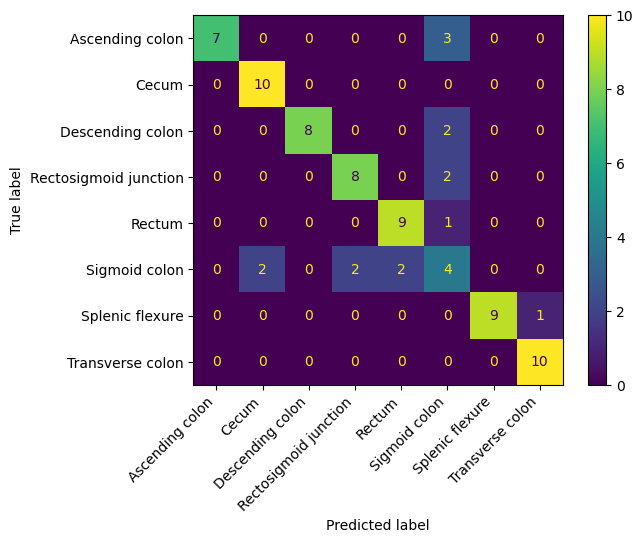

                       precision    recall  f1-score   support

      Ascending colon       1.00      0.70      0.82        10
                Cecum       0.83      1.00      0.91        10
     Descending colon       1.00      0.80      0.89        10
Rectosigmoid junction       0.80      0.80      0.80        10
               Rectum       0.82      0.90      0.86        10
        Sigmoid colon       0.33      0.40      0.36        10
      Splenic flexure       1.00      0.90      0.95        10
     Transverse colon       0.91      1.00      0.95        10

             accuracy                           0.81        80
            macro avg       0.84      0.81      0.82        80
         weighted avg       0.84      0.81      0.82        80



In [9]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Inlcude L1 regularization
    'n_estimators': [20, 50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=8, eval_metric='mlogloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix on the test set
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ascending colon', 'Cecum', 'Descending colon', 'Rectosigmoid junction',
 'Rectum', 'Sigmoid colon', 'Splenic flexure', 'Transverse colon'])
plt.figure(figsize=(8, 6)) 
cm_display.plot() 
plt.xticks(rotation=45, ha='right') 
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Ascending colon', 'Cecum', 'Descending colon', 
 'Rectosigmoid junction', 'Rectum', 'Sigmoid colon', 'Splenic flexure','Transverse colon'])
print(report)

In [10]:
from sklearn.metrics import roc_auc_score

# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=8, eval_metric='mlogloss', **best_params)
y_score = best_xgb_model.fit(X_train, y_train).predict_proba(X_test)

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.96


C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_9888\3610568644.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')


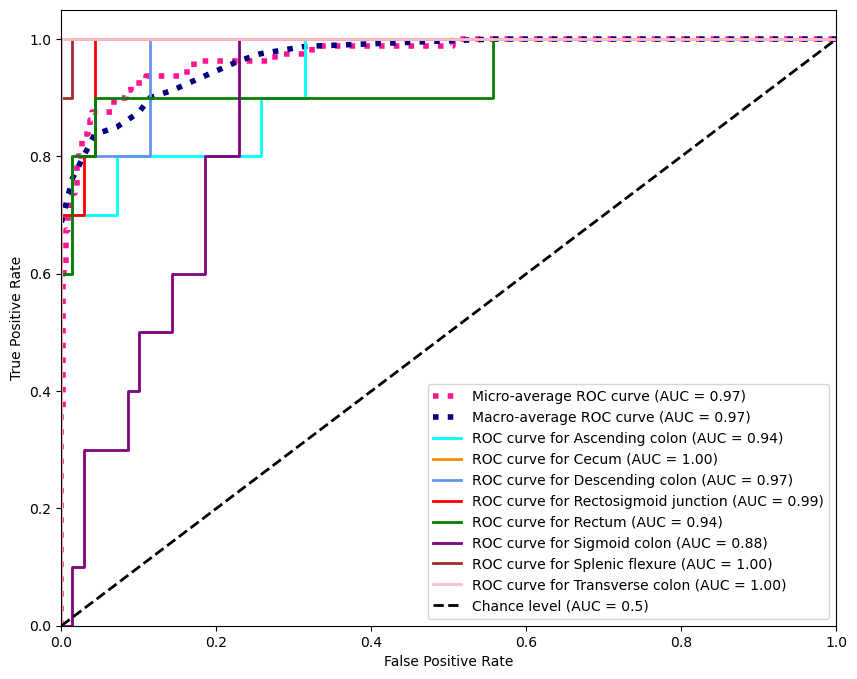

In [11]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.arange(8))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 8

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_9888\2666187678.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


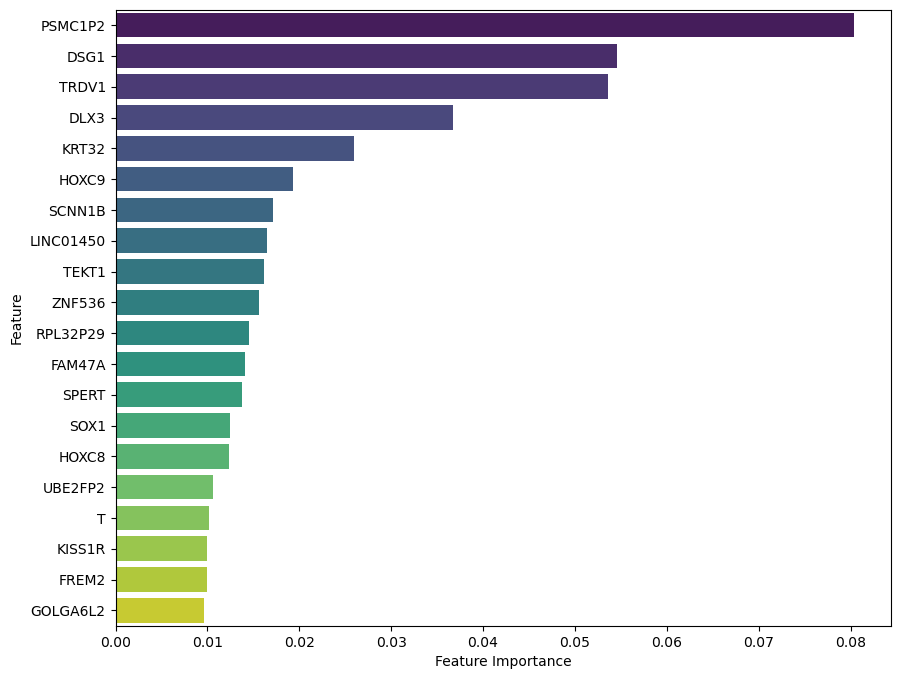

In [12]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=8, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

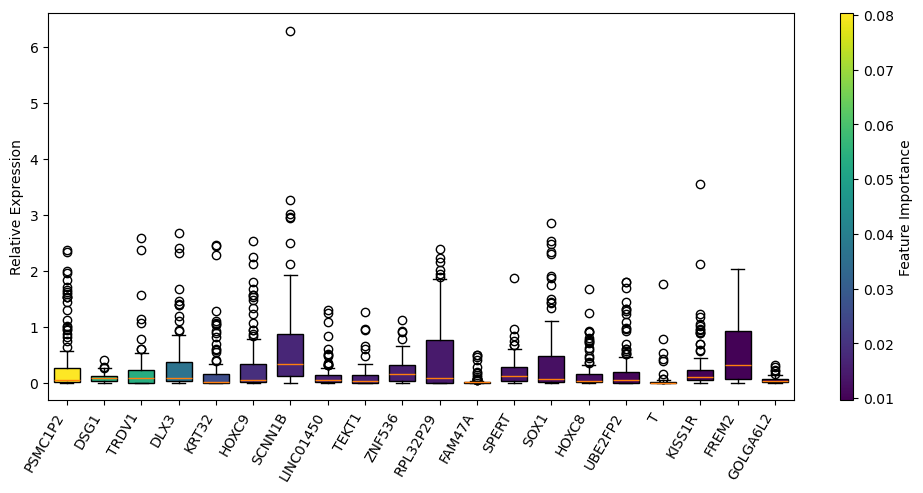

In [13]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

top_20_feature_names = feature_names[top_20_indices]

# Normalize feature importances
norm = Normalize(vmin=min(feature_importances[top_20_indices]), vmax=max(feature_importances[top_20_indices]))
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = [cmap(norm(importance)) for importance in feature_importances[top_20_indices]]

# Prepare data for boxplot
data = {}

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each box with the corresponding color based on feature importance
for i, (key, value) in enumerate(data.items()):
    box = ax.boxplot(value, positions=[i + 1], widths=0.7, patch_artist=True,
                     boxprops=dict(facecolor=colors[i], color='black'),
                     whiskerprops=dict(color='black'))

# Customize plot
ax.set_ylabel('Relative Expression', fontsize=10)
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar, not for plotting
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label('Feature Importance', fontsize=10)

plt.show()